In [380]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from collections import defaultdict

In [173]:
cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492

In [174]:
cali_df = pd.read_csv(cali_housing_path)

In [175]:
print(cali_df.head())

   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.5170

In [176]:
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [358]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [381]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [382]:
subset_indices = np.random.choice(X_train.index, size=len(X_train), replace=False)

X_train_subset = X_train.loc[subset_indices]
y_train_subset = y_train.loc[subset_indices]

print(X_train_scaled.head())

   Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  Households  \
0      -0.220234    0.183029  -0.505330     -0.583271   -0.625333   -0.554684   
1       1.131720   -0.453352  -0.451797     -0.319166   -0.779725   -0.428479   
2       0.635054   -0.930638   0.592095      0.475528    1.118858    0.649526   
3       0.737734   -1.248828  -0.828835     -0.968722   -0.899710   -0.977998   
4      -0.158268   -1.169280  -0.095988     -0.114544   -0.374776   -0.381152   

   Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
0  1.311518  -1.639785          -0.391522        1.490960   
1  1.054222  -1.455058          -0.700199        1.220967   
2  0.764180  -1.110565          -0.144717        0.850569   
3  0.591090  -1.050653          -0.568215        0.701779   
4  1.723191  -0.296764           2.921674        1.372870   

   Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
0              1.449301            -0.918829                 -1.210694  


In [180]:
X_train_subset = X_train_subset.reset_index(drop=True)
y_train_subset = y_train_subset.reset_index(drop=True)

In [181]:
X_train_tensor = tf.constant(X_train_subset.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train_subset.values, dtype=tf.float32)
print(y_train_tensor.shape)

(16512, 1)


In [383]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []
        self.lime_explainer = None

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(X.index, size=subset_size, replace=False)
            X_train = X.loc[subset_indices].reset_index(drop=True)
            y_train = y.loc[subset_indices].reset_index(drop=True)
            
            X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor)
            self.estimators.append(estimator)
            
        self.lime_explainer = LimeTabularExplainer(X.values, feature_names = X.columns.tolist(), mode='regression')
    
    #something's not right here
    def predict_mean(self, X):
        predictions = []
        
        for estimator in self.estimators:
            estimator_predictions = estimator.predict(X)  # Get predictions from the current estimator
            predictions.append(estimator_predictions)
        
        # Stack all predictions along the last axis (-1)
        predictions_stacked = tf.stack(predictions, axis=-1)
        
        # Compute mean and variance across the stacked predictions
        mean_prediction = tf.reduce_mean(predictions_stacked, axis=-1)
        sd_prediction = tf.math.reduce_std(predictions_stacked, axis=-1)
        
        return mean_prediction, sd_prediction
    
    def explain_lime(self, X):
        explanations = []
        
        for estimator in self.estimators:
            for i in range(len(X)): 
                instance_explanation = self.lime_explainer.explain_instance(X.iloc[i], estimator.predict, num_features=X.shape[1])
                explanations.append(instance_explanation)
        return explanations
    
    

In [384]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [385]:
gbt_model.fit(X_train_scaled, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9bn3hnu as temporary training directory
Reading training dataset...


[WARNING 24-05-30 17:32:48.7411 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:48.7412 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:48.7412 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.633424. Found 13209 examples.
Training model...
Model trained in 0:00:00.454386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6or7t1c7 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:49.8324 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9bn3hnu/model/ with prefix 8eface0bd8984ca0
[INFO 24-05-30 17:32:49.8340 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-30 17:32:49.8340 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:49.9368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:49.9368 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:49.9368 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251135. Found 13209 examples.
Training model...
Model trained in 0:00:00.133048
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzsbvas0s as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:50.3225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6or7t1c7/model/ with prefix 6541a884282848cd
[INFO 24-05-30 17:32:50.3232 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:50.4203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:50.4203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:50.4204 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247042. Found 13209 examples.
Training model...
Model trained in 0:00:00.356401
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwc0cda3c as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:51.0247 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzsbvas0s/model/ with prefix 106ae839a6e84d10
[INFO 24-05-30 17:32:51.0261 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:51.1066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:51.1067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:51.1067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245717. Found 13209 examples.
Training model...
Model trained in 0:00:00.275813
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvuy7t0_ as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:51.6338 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwc0cda3c/model/ with prefix de327a1c9a8f4aee
[INFO 24-05-30 17:32:51.6350 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:51.7173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:51.7174 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:51.7174 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242294. Found 13209 examples.
Training model...
Model trained in 0:00:00.186018
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprf_v3x5h as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:52.1473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvuy7t0_/model/ with prefix 58c8bf086a7d48a2
[INFO 24-05-30 17:32:52.1481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:52.2318 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:52.2319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:52.2319 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239029. Found 13209 examples.
Training model...
Model trained in 0:00:00.373204
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtvgc9tp as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:52.8447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprf_v3x5h/model/ with prefix ee94732171a84d58
[INFO 24-05-30 17:32:52.8462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:52.9216 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:52.9216 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:52.9216 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243031. Found 13209 examples.
Training model...
Model trained in 0:00:00.366908
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8wvor9n as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:53.5367 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtvgc9tp/model/ with prefix 232d36ad13854c92
[INFO 24-05-30 17:32:53.5383 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:53.6218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:53.6218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:53.6218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239254. Found 13209 examples.
Training model...
Model trained in 0:00:00.317852
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsbpo7xgk as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:54.1798 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8wvor9n/model/ with prefix ce345b04ada64873
[INFO 24-05-30 17:32:54.1812 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:54.2574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:54.2574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:54.2574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233527. Found 13209 examples.
Training model...
Model trained in 0:00:00.227564
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquom3x2e as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:54.7243 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsbpo7xgk/model/ with prefix 327ee940a54743bb
[INFO 24-05-30 17:32:54.7253 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:54.8067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:54.8068 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:54.8068 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245288. Found 13209 examples.
Training model...
Model trained in 0:00:00.339579
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppv26dlq8 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:55.3926 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquom3x2e/model/ with prefix 07dadf4b27ab42d8
[INFO 24-05-30 17:32:55.3940 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:55.4688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:55.4688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:55.4688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239364. Found 13209 examples.
Training model...
Model trained in 0:00:00.375659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqfkzsgfk as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:56.0892 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppv26dlq8/model/ with prefix eaa866e88ed243c1
[INFO 24-05-30 17:32:56.0908 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:56.1730 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:56.1730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:56.1730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235812. Found 13209 examples.
Training model...
Model trained in 0:00:00.344657
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprytchadr as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:56.7541 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqfkzsgfk/model/ with prefix 162c7b1184134e61
[INFO 24-05-30 17:32:56.7556 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:56.8291 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:56.8292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:56.8292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239955. Found 13209 examples.
Training model...
Model trained in 0:00:00.375824
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq2vdmw6v as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:57.4500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprytchadr/model/ with prefix ef4c3460d6a34a07
[INFO 24-05-30 17:32:57.4516 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:57.5300 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:57.5300 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:57.5300 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237180. Found 13209 examples.
Training model...
Model trained in 0:00:00.183286
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwnjbols2 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:57.9515 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq2vdmw6v/model/ with prefix b043c494b488478b
[INFO 24-05-30 17:32:57.9525 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:58.0293 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:58.0293 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:58.0293 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238235. Found 13209 examples.
Training model...
Model trained in 0:00:00.178656
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50fkimw8 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:58.4517 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwnjbols2/model/ with prefix 4c5eb55b6c05472d
[INFO 24-05-30 17:32:58.4526 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:58.5332 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:58.5333 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:58.5333 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240835. Found 13209 examples.
Training model...
Model trained in 0:00:00.214111
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnnjlby8z as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:58.9892 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50fkimw8/model/ with prefix 61eea62b77714025
[INFO 24-05-30 17:32:58.9902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:59.0768 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:59.0768 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:59.0768 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240036. Found 13209 examples.
Training model...
Model trained in 0:00:00.328347
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplvpwfvch as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:32:59.6458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnnjlby8z/model/ with prefix 86d705d38c374f5b
[INFO 24-05-30 17:32:59.6473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:32:59.7248 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:59.7248 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:32:59.7248 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237577. Found 13209 examples.
Training model...
Model trained in 0:00:00.245856
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnw6ug1b as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:00.2143 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplvpwfvch/model/ with prefix f8c1f2ef58734522
[INFO 24-05-30 17:33:00.2154 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-30 17:33:00.2154 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:00.2907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:00.2907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:00.2907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237982. Found 13209 examples.
Training model...
Model trained in 0:00:00.270112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6vvhr5dz as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:00.8044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnw6ug1b/model/ with prefix 60a6e61d339f4543
[INFO 24-05-30 17:33:00.8056 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:00.8788 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:00.8788 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:00.8788 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243614. Found 13209 examples.
Training model...
Model trained in 0:00:00.326188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptx2mf3lm as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:01.4543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6vvhr5dz/model/ with prefix 3cf1c3907df64f2d
[INFO 24-05-30 17:33:01.4557 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:01.5309 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:01.5309 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:01.5309 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234996. Found 13209 examples.
Training model...
Model trained in 0:00:00.174257
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6htnc_c9 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:01.9462 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptx2mf3lm/model/ with prefix e70b8ba62a1547ba
[INFO 24-05-30 17:33:01.9470 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:02.0212 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:02.0212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:02.0212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235928. Found 13209 examples.
Training model...
Model trained in 0:00:00.393763
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyt_arcar as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:02.6563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6htnc_c9/model/ with prefix 861c9b8751844a56
[INFO 24-05-30 17:33:02.6579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:02.7313 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:02.7313 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:02.7313 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235883. Found 13209 examples.
Training model...
Model trained in 0:00:00.257184
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pfxo76f as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:03.2301 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyt_arcar/model/ with prefix 7fea43ddee8e4958
[INFO 24-05-30 17:33:03.2313 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:03.3058 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:03.3058 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:03.3058 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235022. Found 13209 examples.
Training model...
Model trained in 0:00:00.195216
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpam6gi618 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:03.7421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pfxo76f/model/ with prefix c19b7b019a6b411b
[INFO 24-05-30 17:33:03.7430 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:03.8179 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:03.8179 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:03.8179 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231867. Found 13209 examples.
Training model...
Model trained in 0:00:00.211158
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ggba67b as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:04.2670 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpam6gi618/model/ with prefix 653247d1ebfe4c3f
[INFO 24-05-30 17:33:04.2680 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:04.3428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:04.3429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:04.3429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242163. Found 13209 examples.
Training model...
Model trained in 0:00:00.139894
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfj_7ph23 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:04.7315 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ggba67b/model/ with prefix c42ebb70d03649c5
[INFO 24-05-30 17:33:04.7321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:04.8087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:04.8087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:04.8087 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234984. Found 13209 examples.
Training model...
Model trained in 0:00:00.346901
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppv58zdoj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:05.3967 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfj_7ph23/model/ with prefix 2c521a7bbeeb4954
[INFO 24-05-30 17:33:05.3982 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:05.4750 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:05.4750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:05.4750 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254737. Found 13209 examples.
Training model...
Model trained in 0:00:00.354228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb0pj5ia4 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:06.0893 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppv58zdoj/model/ with prefix 0bf8eec2195044a0
[INFO 24-05-30 17:33:06.0908 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:06.1662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:06.1662 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:06.1662 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234652. Found 13209 examples.
Training model...
Model trained in 0:00:00.165450
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6xw2n9a as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:06.5728 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb0pj5ia4/model/ with prefix 2fd64da412b64834
[INFO 24-05-30 17:33:06.5737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:06.6495 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:06.6495 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:06.6495 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237956. Found 13209 examples.
Training model...
Model trained in 0:00:00.096931
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph9_enaae as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:06.9909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6xw2n9a/model/ with prefix 5af2adfb1bb741c1
[INFO 24-05-30 17:33:06.9914 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:07.0693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:07.0693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:07.0693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244965. Found 13209 examples.
Training model...
Model trained in 0:00:00.119155
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1jji5a as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:07.4402 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph9_enaae/model/ with prefix 27732c372baa48cc
[INFO 24-05-30 17:33:07.4408 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:07.5183 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:07.5183 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:07.5183 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237827. Found 13209 examples.
Training model...
Model trained in 0:00:00.330571
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48qo3uoz as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:08.0924 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1jji5a/model/ with prefix c0732d1c26554e34
[INFO 24-05-30 17:33:08.0938 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:08.1884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:08.1885 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:08.1885 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239204. Found 13209 examples.
Training model...
Model trained in 0:00:00.362917
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzt32ayu as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:08.7964 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48qo3uoz/model/ with prefix a784146f11af41b7
[INFO 24-05-30 17:33:08.7980 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:08.8719 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:08.8719 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:08.8719 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236960. Found 13209 examples.
Training model...
Model trained in 0:00:00.157987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgqhc2ux as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:09.2734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzt32ayu/model/ with prefix a1a4ee43f3c24bcb
[INFO 24-05-30 17:33:09.2742 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:09.3480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:09.3480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:09.3480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237903. Found 13209 examples.
Training model...
Model trained in 0:00:00.386545
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq70ucvbu as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:09.9773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgqhc2ux/model/ with prefix 1ad168ebdb15442e
[INFO 24-05-30 17:33:09.9791 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:10.0636 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:10.0636 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:10.0636 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240824. Found 13209 examples.
Training model...
Model trained in 0:00:00.209197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cu2er8y as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:10.5201 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq70ucvbu/model/ with prefix 6de5c54e311546ba
[INFO 24-05-30 17:33:10.5211 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-30 17:33:10.5211 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:10.5980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:10.5980 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:10.5981 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236608. Found 13209 examples.
Training model...
Model trained in 0:00:00.409220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplv2fliyo as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:11.2490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cu2er8y/model/ with prefix 0d0dff7c0b6b46b3
[INFO 24-05-30 17:33:11.2507 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:11.3233 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:11.3233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:11.3233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233422. Found 13209 examples.
Training model...
Model trained in 0:00:00.251687
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh_ii5tj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:11.8138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplv2fliyo/model/ with prefix f17b846ba8c04681
[INFO 24-05-30 17:33:11.8150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:11.8887 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:11.8887 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:11.8887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242415. Found 13209 examples.
Training model...
Model trained in 0:00:00.122044
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wg4q4qi as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:12.2597 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh_ii5tj/model/ with prefix 9461a2e367a340e2
[INFO 24-05-30 17:33:12.2604 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:12.3348 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:12.3349 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:12.3349 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232741. Found 13209 examples.
Training model...
Model trained in 0:00:00.249983
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoku5wkhu as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:12.8236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wg4q4qi/model/ with prefix 314203c927044529
[INFO 24-05-30 17:33:12.8247 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:12.8991 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:12.8991 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:12.8991 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238415. Found 13209 examples.
Training model...
Model trained in 0:00:00.335049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilh_aujb as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:13.4783 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoku5wkhu/model/ with prefix 0a72f55d895e455b
[INFO 24-05-30 17:33:13.4797 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:13.5532 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:13.5532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:13.5532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235608. Found 13209 examples.
Training model...
Model trained in 0:00:00.280818
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadmthuv_ as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:14.0751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilh_aujb/model/ with prefix eb5415762fb34c6f
[INFO 24-05-30 17:33:14.0764 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:14.1584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:14.1584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:14.1584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250898. Found 13209 examples.
Training model...
Model trained in 0:00:00.465533
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9mqgebr as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:14.8803 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadmthuv_/model/ with prefix 2e8cc250ea9a4ac2
[INFO 24-05-30 17:33:14.8821 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:14.9617 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:14.9617 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:14.9617 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232953. Found 13209 examples.
Training model...
Model trained in 0:00:00.277677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2au02lyf as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:15.4779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9mqgebr/model/ with prefix 53248346994146eb
[INFO 24-05-30 17:33:15.4792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:15.5576 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:15.5577 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:15.5577 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239812. Found 13209 examples.
Training model...
Model trained in 0:00:00.299620
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnb209kcw as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:16.1087 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2au02lyf/model/ with prefix 22d0aab4a16c4aa4
[INFO 24-05-30 17:33:16.1100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:16.1857 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:16.1858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:16.1858 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263595. Found 13209 examples.
Training model...
Model trained in 0:00:00.189893
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4pm711f3 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:16.6453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnb209kcw/model/ with prefix fa469688bb564e5a
[INFO 24-05-30 17:33:16.6462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:16.7249 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:16.7249 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:16.7249 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236897. Found 13209 examples.
Training model...
Model trained in 0:00:00.370911
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxz8ag5n as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:17.3382 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4pm711f3/model/ with prefix 3e8089445b2e429c
[INFO 24-05-30 17:33:17.3398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:17.4171 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:17.4171 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:17.4172 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.267032. Found 13209 examples.
Training model...
Model trained in 0:00:00.334643
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtjyk341 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:18.0242 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxz8ag5n/model/ with prefix 4cc28e6363dd46fd
[INFO 24-05-30 17:33:18.0255 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:18.1062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:18.1062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:18.1062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240571. Found 13209 examples.
Training model...
Model trained in 0:00:00.163978
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdj4t_0c as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:18.5171 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtjyk341/model/ with prefix 2fd36817bdfa4e17
[INFO 24-05-30 17:33:18.5179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:18.5974 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:18.5974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:18.5974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243474. Found 13209 examples.
Training model...
Model trained in 0:00:00.290861
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgbwga1j as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:19.1375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdj4t_0c/model/ with prefix e93067448f914446
[INFO 24-05-30 17:33:19.1387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:19.2157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:19.2157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:19.2158 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240194. Found 13209 examples.
Training model...
Model trained in 0:00:00.268610
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeh_9pwdj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:19.7304 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgbwga1j/model/ with prefix 725411500f994c68
[INFO 24-05-30 17:33:19.7316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:19.8083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:19.8084 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:19.8084 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241312. Found 13209 examples.
Training model...
Model trained in 0:00:00.341478
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9i9uujld as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:20.3966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeh_9pwdj/model/ with prefix 23355f1291b34943
[INFO 24-05-30 17:33:20.3981 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:20.4721 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:20.4722 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:20.4722 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248474. Found 13209 examples.
Training model...
Model trained in 0:00:00.141591
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjn2c09a_ as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:20.8689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9i9uujld/model/ with prefix 0d5ba1be08af491f
[INFO 24-05-30 17:33:20.8696 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-30 17:33:20.8696 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:20.9451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:20.9451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:20.9451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238656. Found 13209 examples.
Training model...
Model trained in 0:00:00.212825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf0_kmfzl as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:21.4026 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjn2c09a_/model/ with prefix 53636ccf51964325
[INFO 24-05-30 17:33:21.4036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:21.4775 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:21.4775 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:21.4775 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238818. Found 13209 examples.
Training model...
Model trained in 0:00:00.283870
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5y7ahphn as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:22.0062 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf0_kmfzl/model/ with prefix 4306e6ad17144ec4
[INFO 24-05-30 17:33:22.0075 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:22.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:22.0808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:22.0808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233097. Found 13209 examples.
Training model...
Model trained in 0:00:00.325293
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprb6u_v4y as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:22.6450 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5y7ahphn/model/ with prefix b27c3e35da4e46c9
[INFO 24-05-30 17:33:22.6464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:22.7212 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:22.7213 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:22.7213 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.301518. Found 13209 examples.
Training model...
Model trained in 0:00:00.198096
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn2ph7vu7 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:23.2270 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprb6u_v4y/model/ with prefix f89d48ff240849a5
[INFO 24-05-30 17:33:23.2279 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:23.3020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:23.3020 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:23.3020 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238443. Found 13209 examples.
Training model...
Model trained in 0:00:00.168517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpah_hkdhj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:23.7155 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn2ph7vu7/model/ with prefix 96a550212a7b4fa2
[INFO 24-05-30 17:33:23.7163 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:23.7914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:23.7914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:23.7914 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238176. Found 13209 examples.
Training model...
Model trained in 0:00:00.141542
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dtr0bqn as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:24.1778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpah_hkdhj/model/ with prefix 4a7fde93734649b8
[INFO 24-05-30 17:33:24.1785 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:24.2528 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:24.2528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:24.2528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234724. Found 13209 examples.
Training model...
Model trained in 0:00:00.270932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_ohsefj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:24.7648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dtr0bqn/model/ with prefix b68c22fe7e65430c
[INFO 24-05-30 17:33:24.7659 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:24.8401 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:24.8401 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:24.8401 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234468. Found 13209 examples.
Training model...
Model trained in 0:00:00.255255
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vpyvrhj as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:25.3355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_ohsefj/model/ with prefix 15603a6575004633
[INFO 24-05-30 17:33:25.3366 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:25.4142 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:25.4142 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:25.4142 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247418. Found 13209 examples.
Training model...
Model trained in 0:00:00.389643
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_pgcirag as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:26.0567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vpyvrhj/model/ with prefix 131ed42ca0b8441e
[INFO 24-05-30 17:33:26.0583 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:26.1379 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:26.1380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:26.1380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239475. Found 13209 examples.
Training model...
Model trained in 0:00:00.142365
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozdffhs8 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:26.5264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_pgcirag/model/ with prefix a33508ef5d564d3d
[INFO 24-05-30 17:33:26.5271 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:26.6021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:26.6021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:26.6021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237732. Found 13209 examples.
Training model...
Model trained in 0:00:00.137549
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnu91zbi as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:26.9839 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozdffhs8/model/ with prefix 09a8eae9c2c342ab
[INFO 24-05-30 17:33:26.9846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:27.0596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.0596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.0596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239577. Found 13209 examples.
Training model...
Model trained in 0:00:00.114297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1v38mh2a as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:27.4202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnu91zbi/model/ with prefix 222021bb35f346fc
[INFO 24-05-30 17:33:27.4208 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:27.4971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.4971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.4971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240969. Found 13209 examples.
Training model...
Model trained in 0:00:00.100008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn7mwtm7 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:27.8446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1v38mh2a/model/ with prefix 000f43d4967642c9
[INFO 24-05-30 17:33:27.8452 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:27.9189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.9189 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:27.9189 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.253746. Found 13209 examples.
Training model...
Model trained in 0:00:00.268960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpot6eovdk as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:28.4475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn7mwtm7/model/ with prefix cb0a2799184e41e4
[INFO 24-05-30 17:33:28.4487 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:28.5263 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:28.5264 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:28.5264 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258570. Found 13209 examples.
Training model...
Model trained in 0:00:00.354009
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkz1ifv3b as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:29.1449 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpot6eovdk/model/ with prefix 590c7a6e9267498c
[INFO 24-05-30 17:33:29.1465 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:29.2261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:29.2261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:29.2261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.257165. Found 13209 examples.
Training model...
Model trained in 0:00:00.382417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvbq25vdc as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:29.8710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkz1ifv3b/model/ with prefix 89a3105c2b25415d
[INFO 24-05-30 17:33:29.8726 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:29.9511 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:29.9511 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:29.9511 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250391. Found 13209 examples.
Training model...
Model trained in 0:00:00.419344
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnv8x7_nx as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:30.6259 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvbq25vdc/model/ with prefix 48247809705d4fd0
[INFO 24-05-30 17:33:30.6276 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:30.7082 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:30.7082 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:30.7082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244309. Found 13209 examples.
Training model...
Model trained in 0:00:00.229228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5fsbi0k as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:31.1879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnv8x7_nx/model/ with prefix 1961633bf1164a85
[INFO 24-05-30 17:33:31.1889 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-30 17:33:31.1889 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:31.2687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:31.2687 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:31.2687 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249502. Found 13209 examples.
Training model...
Model trained in 0:00:00.366593
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprm8al_my as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:31.8909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5fsbi0k/model/ with prefix b77512ed1fba481a
[INFO 24-05-30 17:33:31.8922 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:31.9679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:31.9679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:31.9680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239647. Found 13209 examples.
Training model...
Model trained in 0:00:00.265222
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj5xn0ng as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:32.4791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprm8al_my/model/ with prefix 0fcdc25440274ab1
[INFO 24-05-30 17:33:32.4803 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:32.5562 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:32.5562 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:32.5562 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240978. Found 13209 examples.
Training model...
Model trained in 0:00:00.343413
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4kmljin as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:33.1463 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj5xn0ng/model/ with prefix 4a58b865f452400e
[INFO 24-05-30 17:33:33.1477 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:33.2240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:33.2240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:33.2240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235481. Found 13209 examples.
Training model...
Model trained in 0:00:00.348078
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kbpkmri as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:33.8132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4kmljin/model/ with prefix 11c84b3eb9b94030
[INFO 24-05-30 17:33:33.8147 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:33.8886 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:33.8886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:33.8886 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248480. Found 13209 examples.
Training model...
Model trained in 0:00:00.320604
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4aa590f as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:34.4635 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kbpkmri/model/ with prefix 595c3a4ecc39431d
[INFO 24-05-30 17:33:34.4650 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:34.5410 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:34.5410 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:34.5410 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240971. Found 13209 examples.
Training model...
Model trained in 0:00:00.319361
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2u81nlr as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:35.1072 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4aa590f/model/ with prefix bdc94a8ba4a7417d
[INFO 24-05-30 17:33:35.1086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:35.1863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:35.1863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:35.1863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239600. Found 13209 examples.
Training model...
Model trained in 0:00:00.361283
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1rcq62o as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:35.7932 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2u81nlr/model/ with prefix 58696d38450f4910
[INFO 24-05-30 17:33:35.7946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:35.8681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:35.8682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:35.8682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237154. Found 13209 examples.
Training model...
Model trained in 0:00:00.182316
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmynrlie6 as temporary training directory
Reading training dataset...


[INFO 24-05-30 17:33:36.2943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1rcq62o/model/ with prefix a3c25eee3ab04e8b
[INFO 24-05-30 17:33:36.2952 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-30 17:33:36.3685 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:36.3685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-30 17:33:36.3685 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236004. Found 13209 examples.
Training model...
Model trained in 0:00:00.305750
Compiling model...
Model compiled.


[INFO 24-05-30 17:33:36.9164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmynrlie6/model/ with prefix 7a0dc775fd0d4c0b
[INFO 24-05-30 17:33:36.9177 CEST kernel.cc:1061] Use fast generic engine


In [386]:
mean_predict, variance_predict = gbt_model.predict_mean(X_test_scaled)

129/129 [==============================] - 0s 507us/step


In [276]:
y_test_eval = np.array(y_test).flatten()
y_pred_eval = mean_predict.numpy().flatten()

In [277]:
print(mean_predict.dtype)

<dtype: 'float32'>


In [188]:
root_mse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(root_mse)

60781.94715085922


In [170]:
indices_max = tf.where(tf.equal(variance_predict, max(variance_predict)))
index_max_uncertainty = indices_max[0][0]
indices_min = tf.where(tf.equal(variance_predict, min(variance_predict)))
index_min_uncertainty = indices_min[0][0]

In [171]:
y_plot_m = [y_test[index_min_uncertainty],y_test[index_max_uncertainty]]
x_axis = np.arange(len(y_plot_m))
y_mean_predict_m = [mean_predict[index_min_uncertainty], mean_predict[index_max_uncertainty]]
y_std_predict_m = [variance_predict[index_min_uncertainty],variance_predict[index_max_uncertainty]]

InvalidIndexError: tf.Tensor(2886, shape=(), dtype=int64)

In [387]:
PLOT = 30

In [388]:
y_plot = y_test[:PLOT]
x_axis = np.arange(len(y_plot))
y_mean_predict = mean_predict[:PLOT].numpy()
y_var_predict = variance_predict[:PLOT].numpy()

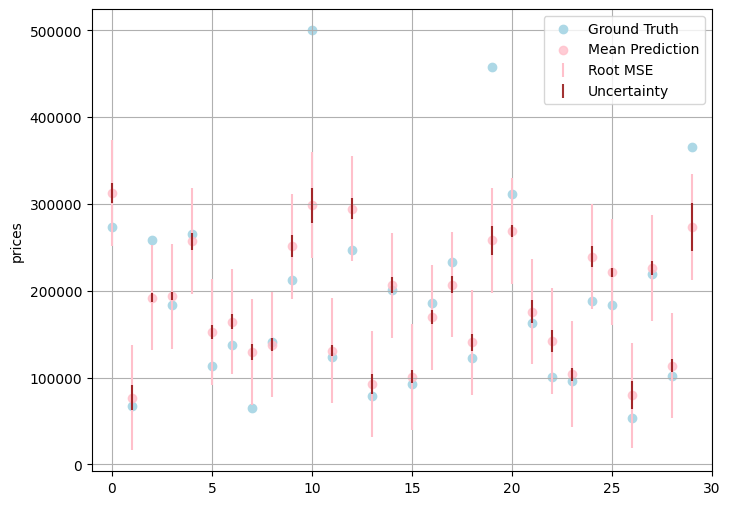

In [389]:
plt.figure(figsize=(8, 6))
plt.xlim(-1,PLOT)
plt.scatter(x_axis, y_plot, color='lightblue', label="Ground Truth")
plt.scatter(x_axis, y_mean_predict.flatten(), color='pink', alpha=0.8, label='Mean Prediction')
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=root_mse, fmt='none', ecolor='pink', label="Root MSE")
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=y_var_predict.flatten(), fmt='none', color='darkred', alpha=0.8, label="Uncertainty")
plt.ylabel('prices')
plt.legend()
plt.grid(True)  # Enable grid for better visualization
plt.show()

In [ ]:
# find the data points with the largest and smallest difference

In [390]:
print(y_test.loc[[10]])

    Median_House_Value
29            366100.0


In [395]:
gbt_explanation=gbt_model.explain_lime(X_test.loc[[10]])

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 15s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 25/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 17/157 [==>...........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 84/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 25/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 20/157 [==>...........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 45/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 6s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 47/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 23/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 16s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [371]:
for i, explanation in enumerate(gbt_explanation):
    print(f"Explanation {i + 1}:")
    print("As List of Tuples (feature_id, weight):")
    for feature_id, weight in explanation.as_list():
        print(f"Feature {feature_id}: {weight}")

    print("\n")

Explanation 1:
As List of Tuples (feature_id, weight):
Feature Distance_to_LA <= 32276.58: 38206.070944785184
Feature Tot_Bedrooms > 648.00: 17938.916571757378
Feature 9090.97 < Distance_to_coast <= 20514.18: 15929.48485020582
Feature Tot_Rooms > 3157.00: 15609.68659648016
Feature 1170.00 < Population <= 1734.00: -10011.0610359285
Feature 33.93 < Latitude <= 34.26: 8932.826044516432
Feature 29.00 < Median_Age <= 37.00: 7136.599361866089
Feature 3.53 < Median_Income <= 4.73: -5408.976643505399
Feature 458975.82 < Distance_to_SanJose <= 516638.86: -2935.4796385583873
Feature -118.50 < Longitude <= -118.01: -1295.396186489745
Feature 525923.80 < Distance_to_SanFrancisco <= 584341.68: -667.28625060089
Feature 159313.07 < Distance_to_SanDiego <= 215956.69: 275.814925609609
Feature Households > 607.00: -8.052422640376497


Explanation 2:
As List of Tuples (feature_id, weight):
Feature Distance_to_LA <= 32276.58: 20365.754999454257
Feature 9090.97 < Distance_to_coast <= 20514.18: 15825.230908

In [396]:
feature_weights = defaultdict(list)

for explanation in gbt_explanation:
    for feature, weight in explanation.as_list():
        feature_weights[feature].append(weight)

feature_stats = {}
for feature, weights in feature_weights.items():
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)
    feature_stats[feature] = {'mean': mean_weight, 'std': std_weight}

print(feature_stats)

{'Median_Income > 0.46': {'mean': 147096.37506307272, 'std': 9053.852184863821}, 'Distance_to_coast > 0.19': {'mean': -68023.32681428803, 'std': 5648.765446104749}, 'Latitude > 0.97': {'mean': -24225.197258490392, 'std': 7088.677867307465}, 'Distance_to_LA > 1.04': {'mean': -12098.841204425542, 'std': 4303.773253343923}, 'Population > 0.27': {'mean': -6781.898405551049, 'std': 5929.4245972663275}, 'Tot_Bedrooms > 0.26': {'mean': 7807.712485636308, 'std': 5140.008529499596}, 'Longitude <= -1.11': {'mean': 5665.329972244105, 'std': 3791.037262612245}, 'Median_Age > 0.66': {'mean': 8830.583280686924, 'std': 2194.0370025858283}, 'Distance_to_SanJose > 0.77': {'mean': -7380.620180582075, 'std': 2917.581858147634}, 'Tot_Rooms > 0.24': {'mean': 5134.867858308828, 'std': 4810.782289748073}, 'Distance_to_SanFrancisco > 0.79': {'mean': -4146.053273279047, 'std': 2494.5827956810276}, 'Households > 0.28': {'mean': 1741.339797700374, 'std': 2271.0280016824927}, 'Distance_to_SanDiego > 1.06': {'mean

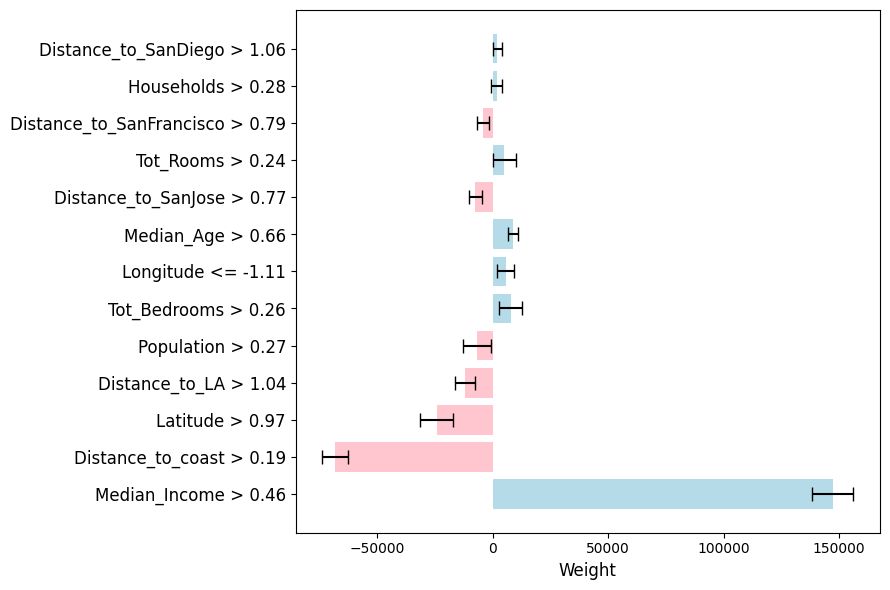

In [397]:
features = list(feature_stats.keys())
mean_weights = [feature_stats[feature]['mean'] for feature in features]
std_weights = [feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

In [299]:
num = len(X_test)

In [300]:
print(num)

4128
